In [232]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import EoN
import utils

# Network setup
G = nx.barabasi_albert_graph(10**6, 5)
avg_deg = np.mean(list(G.degree), axis=0)[1]
rk_norm = EoN.get_PGFDPrime(EoN.get_Pk(G))(1)

pk = dict(sorted(EoN.get_Pk(G).items()))
qk = dict((k-1, k * p / avg_deg) for k, p in pk.items())
rk = dict((k-2, k*(k-1)*p / rk_norm) for k, p in pk.items())

ccdfs = list(map(utils.ccdf_from_pk, [pk, qk, rk]))

# Epidemic simulation
params = {'tmax': 100,  
          'tau': 0.1,    # transmission rate (for edges)
          'gamma': 1,  # recovery rate (for nodes)
          'rho': 0.00001,  # initial seed fraction
         }
print("Estimated R0: {:.2f}".format(
    EoN.estimate_R0(G, transmissibility = params['tau']/(params['tau']+params['gamma']))
))
sim_data = EoN.fast_SIR(G, return_full_data=True, **params)
T = sim_data.transmission_tree()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Estimated R0: 3.75


In [290]:
t = 2
infected = [x for x in utils.nodes_with_given_state_at_time(t, "I", sim_data, G.nodes())]
print('there are ', len(infected), 'infected nodes at t={}'.format(t))

infected_with_successors = [x for x in infected if x in T and list(T.successors(x))]
print('there are ', len(infected_with_successors), 'infected nodes at t={}'.format(t), 
      'that have a parent and have spread the infection.')

there are  494 infected nodes at t=2
there are  299 infected nodes at t=2 that have a parent and have spread the infection.


In [338]:
p_s = 0.01
p_t = 0.5
p_r = 0.5

t = 3
delta = 0.5

X = []
num_traced = []
fraction_traced = []
tot_list = []
tr_tot_list = []
for p_s in np.linspace(0.01, 1.0, 100):
    np.random.shuffle(infected)
    infected_sampled = infected[:int(len(infected)*p_s)]
    #print('# infected', len(infected))
    #print('# infected & identified', len(infected_sampled))

    to_be_traced = Counter()
    for node in infected_sampled:
        if node in T and list(T.predecessors(node)):
            parent = list(T.predecessors(node))[0]
            temp = [x for x in G.neighbors(node) if x == parent or np.random.random() < p_t]
        else:
            temp = [x for x in G.neighbors(node) if np.random.random() < p_t]
        for i in temp:
            if np.random.random() < p_r:
                to_be_traced[i] += 1

    traced = set(to_be_traced.keys()) | set(infected_sampled)
    X.append(p_s)
    num_traced.append(len(traced))
    fraction_traced.append( len(set(infected_with_successors) & traced)*1.0/len(infected_with_successors) )

    tot = 0
    for node in infected:
        for v in T[node]:
            ts = T[node][v][0]['time']
            if ts >= t and ts < t + delta:
                tot += 1

    traced_tot = 0
    for node in traced:
        if node in infected:
            for v in T[node]:
                ts = T[node][v][0]['time']
                if ts >= t and ts < t + delta:
                    traced_tot += 1

    tot_list.append(tot)
    tr_tot_list.append(traced_tot/tot)

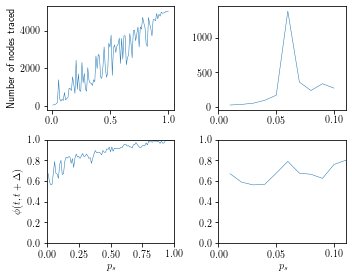

In [342]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5,4))

ax1.plot(X, num_traced, linewidth=0.5)
ax1.set_ylabel("Number of nodes traced")

ax2.set_xlim(0, X[10])
ax2.plot(X[:10], num_traced[:10], linewidth=0.5)

ax3.set_xlim(0.0, 1.0)
ax3.set_ylim(0, 1.0)
ax3.set_xlabel(r"$p_s$")
ax3.set_ylabel("$\phi (t, t + \Delta)$")
ax3.plot(X, tr_tot_list, linewidth=0.5)

ax4.set_xlabel(r"$p_s$")
ax4.set_ylim(0, 1.0)
ax4.set_xlim(0.0, X[10])
ax4.plot(X, tr_tot_list, linewidth=0.5)

plt.tight_layout()
plt.savefig('../figs/fig3.pdf')

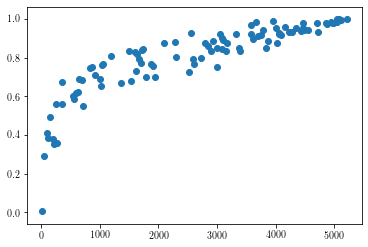

In [337]:
plt.scatter(num_traced, tr_tot_list)

for the nodes in the set `traced`, we count how many edges we are removing between $t_0$ and $t_0 + \Delta$

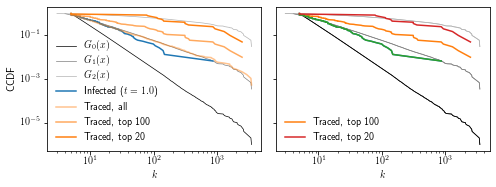

In [158]:
top_to_be_traced = [x[0] for x in to_be_traced.most_common(topn)]

# Plotting
infected_ccdf = utils.ccdf_from_data(list(dict(G.degree(infected_sampled)).values()))
traced_ccdf = utils.ccdf_from_data(list(dict(G.degree(to_be_traced.keys())).values()))
traced100_ccdf = utils.ccdf_from_data(list(dict(G.degree(
                                        [x[0] for x in to_be_traced.most_common(100)]
                                        )).values()))
traced20_ccdf = utils.ccdf_from_data(list(dict(G.degree(
                                        [x[0] for x in to_be_traced.most_common(20)]
                                        )).values()))
plot_kwargs_for_base_ccdfs = [
    {"label": r"$G_0(x)$", "color": (0, 0, 0), 'linewidth': 0.7}, 
    {"label": r"$G_1(x)$", "color": (0.5, 0.5, 0.5), 'linewidth': 0.7}, 
    {"label": r"$G_2(x)$", "color": (0.7, 0.7, 0.7), 'linewidth': 0.7}, 
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,2.7), sharey=True)
utils.loglog_plot(ccdfs + [infected_ccdf, traced_ccdf, traced100_ccdf, traced20_ccdf], 
                  kwargs_list=plot_kwargs_for_base_ccdfs + [
                      {'label':r"Infected ($t={:.1f}$)".format(t)},
                      {'label':r"Traced, all", 'color': '#ff7f0e77'},
                      {'label':r"Traced, top 100", 'color': '#ff7f0eaa'},
                      {'label':r"Traced, top 20", 'color': "#ff7f0eff"},
                  ],
                  xlabel=r"$k$", ylabel="CCDF", ax=ax1)
utils.loglog_plot(ccdfs + [infected_ccdf, traced100_ccdf], 
                  kwargs_list=[
                      {"color": (0, 0, 0), 'linewidth': 0.7},
                      {"color": (0.5, 0.5, 0.5), 'linewidth': 0.7},
                      {"color": (0.7, 0.7, 0.7), 'linewidth': 0.7},
                      {},
                      {'label':r"Traced, top 100"}
                  ],
                  xlabel=r"$k$", ylabel=None, ax=ax2)
utils.loglog_plot(ccdfs + [infected_ccdf, traced20_ccdf], 
                  kwargs_list=[
                      {"color": (0, 0, 0), 'linewidth': 0.7},
                      {"color": (0.5, 0.5, 0.5), 'linewidth': 0.7},
                      {"color": (0.7, 0.7, 0.7), 'linewidth': 0.7},
                      {},
                      {'label':r"Traced, top 20"}
                  ],
                  xlabel=r"$k$", ylabel=None, ax=ax2)    

